# Linear Regression on house price and migration

## Import dependencies

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import mitosheet
import sqlalchemy as db
from sqlalchemy import create_engine 
from config import host_name,db_password,user_name,db_name

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [75]:
df_XY.head()

,State_and_County,%_Change_Due_to_Migration,percent_price_change_2015_19
0,"Abbeville County, South Carolina",0.004436,0.170454
1,"Acadia Parish, Louisiana",-0.027138,0.100273
2,"Accomack County, Virginia",-0.028954,0.073734
3,"Ada County, Idaho",0.011338,0.632257
4,"Adair County, Iowa",-0.057103,0.062842


## Create connection to SQL database and load table into dataframe

In [76]:
connection_string =f"postgresql://{user_name}:{db_password}@{host_name}:5432/{db_name}"
engine = create_engine(connection_string) 
connection = engine.connect()
metadata = db.MetaData()

In [77]:
# Set up to read from Migration_house_price
Migration_house_price = db.Table('house_price_migration_in_out', metadata, autoload=True, autoload_with=engine)

In [78]:
# Setup query to pull data from Postgres db table Migration_house_price
query = db.select([Migration_house_price]) 
ResultProxy = connection.execute(query)
ResultSet = ResultProxy.fetchall()

In [79]:
# Convert to dataframe
Migration_House_Price_df = pd.DataFrame(ResultSet)
Migration_House_Price_df.columns = ResultSet[0].keys()

In [80]:
Migration_House_Price_df.head()

,state_name_of_geography_a,county_name_of_geography_a,state_and_county_of_geography_a,region_code_geography_a,state_us_island_area_foreign_region_of_geography_b,county_name_of_geography_b,state_and_county_of_geography_b,flow_from_geography_b_to_geography_a,counterflow_from_geography_a_to_geography_b,net_migration_from_geography_b_to_geography_a1,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,percent_price_change_2015_19
0,Alabama,Autauga County,"Autauga County, Alabama",1001,Alabama,Baldwin County,"Baldwin County, Alabama",25,448.0,-423.0,...,120.7,121.5,121.33,122.87,125.49,129.26,130.31,135.3,135.86,0.115141
1,Alabama,Autauga County,"Autauga County, Alabama",1001,Alabama,Barbour County,"Barbour County, Alabama",4,0.0,4.0,...,120.7,121.5,121.33,122.87,125.49,129.26,130.31,135.3,135.86,0.115141
2,Alabama,Autauga County,"Autauga County, Alabama",1001,Alabama,Bibb County,"Bibb County, Alabama",10,34.0,-24.0,...,120.7,121.5,121.33,122.87,125.49,129.26,130.31,135.3,135.86,0.115141
3,Alabama,Autauga County,"Autauga County, Alabama",1001,Alabama,Blount County,"Blount County, Alabama",3,0.0,3.0,...,120.7,121.5,121.33,122.87,125.49,129.26,130.31,135.3,135.86,0.115141
4,Alabama,Autauga County,"Autauga County, Alabama",1001,Alabama,Calhoun County,"Calhoun County, Alabama",2,42.0,-40.0,...,120.7,121.5,121.33,122.87,125.49,129.26,130.31,135.3,135.86,0.115141


In [81]:
# close connection to SQL database
connection.close()

## Clean dataframes

### Clean up price change

In [82]:
# Select columns for State and County A and housing price change percentage

price_change_df = Migration_House_Price_df[['state_and_county_of_geography_a','percent_price_change_2015_19']]
price_change_df.head()

,state_and_county_of_geography_a,percent_price_change_2015_19
0,"Autauga County, Alabama",0.115141
1,"Autauga County, Alabama",0.115141
2,"Autauga County, Alabama",0.115141
3,"Autauga County, Alabama",0.115141
4,"Autauga County, Alabama",0.115141


In [83]:
# Use groupby() and mean() to get rid of duplicate rows

price_change_df = price_change_df.groupby(['state_and_county_of_geography_a'], as_index=False).mean()
price_change_df.head()

,state_and_county_of_geography_a,percent_price_change_2015_19
0,"Abbeville County, South Carolina",0.170454
1,"Acadia Parish, Louisiana",0.100273
2,"Accomack County, Virginia",0.073734
3,"Ada County, Idaho",0.632257
4,"Adair County, Iowa",0.062842


In [84]:
# rename column
price_change_df.rename(columns={'state_and_county_of_geography_a':'State_and_County'}, inplace=True)
price_change_df.head()

,State_and_County,percent_price_change_2015_19
0,"Abbeville County, South Carolina",0.170454
1,"Acadia Parish, Louisiana",0.100273
2,"Accomack County, Virginia",0.073734
3,"Ada County, Idaho",0.632257
4,"Adair County, Iowa",0.062842


### Clean up net migration

In [85]:
net_migration_df = Migration_House_Price_df[['state_and_county_of_geography_a','net_migration_from_geography_b_to_geography_a1']]
net_migration_df.head()

,state_and_county_of_geography_a,net_migration_from_geography_b_to_geography_a1
0,"Autauga County, Alabama",-423.0
1,"Autauga County, Alabama",4.0
2,"Autauga County, Alabama",-24.0
3,"Autauga County, Alabama",3.0
4,"Autauga County, Alabama",-40.0


In [86]:
# Find sum of net migration per county
net_migration_df = net_migration_df.groupby(['state_and_county_of_geography_a'], as_index=False).sum()
net_migration_df.head()

,state_and_county_of_geography_a,net_migration_from_geography_b_to_geography_a1
0,"Abbeville County, South Carolina",110.0
1,"Acadia Parish, Louisiana",-1701.0
2,"Accomack County, Virginia",-953.0
3,"Ada County, Idaho",4908.0
4,"Adair County, Iowa",-408.0


In [87]:
net_migration_df.rename(columns={'state_and_county_of_geography_a':'State_and_County', 
                                  'net_migration_from_geography_b_to_geography_a1':'Net_Migration'}, inplace=True)
net_migration_df.head()

,State_and_County,Net_Migration
0,"Abbeville County, South Carolina",110.0
1,"Acadia Parish, Louisiana",-1701.0
2,"Accomack County, Virginia",-953.0
3,"Ada County, Idaho",4908.0
4,"Adair County, Iowa",-408.0


### Pulling in total population figures

In [88]:
# load total county population data into dataframe
county_pop_df = pd.read_csv('Resources/County_population_totals_2010_2019_co-est2019-alldata.csv',encoding = "ISO-8859-1")
county_pop_df.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,State and County name,CENSUS2010POP,ESTIMATESBASE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,"Alabama, Alabama",4779736,4780125,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,"Autauga County, Alabama",54571,54597,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,"Baldwin County, Alabama",182265,182265,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,"Barbour County, Alabama",27457,27455,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,"Bibb County, Alabama",22915,22915,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [89]:
# Filter out columns irrelevant to 2015 population and rename columns
county_pop_2015_df = county_pop_df[['State and County name','POPESTIMATE2015']]
county_pop_2015_df.rename(columns={'State and County name':'State_and_County', 'POPESTIMATE2015':'Population_2015'}, inplace=True)
county_pop_2015_df.head()

,State_and_County,Population_2015
0,"Alabama, Alabama",4852347
1,"Autauga County, Alabama",54864
2,"Baldwin County, Alabama",202939
3,"Barbour County, Alabama",26283
4,"Bibb County, Alabama",22566


In [90]:
# merge net migration and total population data frames
migration_percentage_df = county_pop_2015_df.merge(net_migration_df, on='State_and_County')
migration_percentage_df.head()

,State_and_County,Population_2015,Net_Migration
0,"Autauga County, Alabama",54864,-2535.0
1,"Baldwin County, Alabama",202939,2295.0
2,"Barbour County, Alabama",26283,-287.0
3,"Bibb County, Alabama",22566,156.0
4,"Blount County, Alabama",57526,-753.0


In [91]:
# calculate population change due to migration
migration_percentage_df['%_Change_Due_to_Migration'] = migration_percentage_df['Net_Migration']/migration_percentage_df['Population_2015']
migration_percentage_df.head()

,State_and_County,Population_2015,Net_Migration,%_Change_Due_to_Migration
0,"Autauga County, Alabama",54864,-2535.0,-0.046205
1,"Baldwin County, Alabama",202939,2295.0,0.011309
2,"Barbour County, Alabama",26283,-287.0,-0.010920
3,"Bibb County, Alabama",22566,156.0,0.006913
4,"Blount County, Alabama",57526,-753.0,-0.013090


## Combine price change and migration dataframes

In [92]:
# merge with price change dataframe
price_migration_df = price_change_df.merge(migration_percentage_df, on='State_and_County')
price_migration_df.head()

,State_and_County,percent_price_change_2015_19,Population_2015,Net_Migration,%_Change_Due_to_Migration
0,"Abbeville County, South Carolina",0.170454,24796,110.0,0.004436
1,"Acadia Parish, Louisiana",0.100273,62679,-1701.0,-0.027138
2,"Accomack County, Virginia",0.073734,32914,-953.0,-0.028954
3,"Ada County, Idaho",0.632257,432862,4908.0,0.011338
4,"Adair County, Iowa",0.062842,7145,-408.0,-0.057103


In [93]:
df_XY = price_migration_df[['State_and_County','%_Change_Due_to_Migration','percent_price_change_2015_19']].dropna()
df_XY.head()

,State_and_County,%_Change_Due_to_Migration,percent_price_change_2015_19
0,"Abbeville County, South Carolina",0.004436,0.170454
1,"Acadia Parish, Louisiana",-0.027138,0.100273
2,"Accomack County, Virginia",-0.028954,0.073734
3,"Ada County, Idaho",0.011338,0.632257
4,"Adair County, Iowa",-0.057103,0.062842


## Describing the data before regression

In [94]:
# Descriptive statistics
df_XY.describe()

,%_Change_Due_to_Migration,percent_price_change_2015_19
count,2339.000000,2339.000000
mean,0.001512,0.212499
std,0.021240,0.127012
min,-0.102752,-0.183043
25%,-0.009572,0.125285
50%,0.000914,0.188886
75%,0.012298,0.277215
max,0.129182,0.776181


## Adding a scatter plot

In [95]:
# Import plotly and create a figure
import plotly.graph_objects as go
fig = go.Figure()



# Add the scatter traces to the figure
for column_header in ['%_Change_Due_to_Migration']:
    fig.add_trace(go.Scatter(
        x=df_XY[column_header],
        y=df_XY['percent_price_change_2015_19'],
        mode='markers',
        name=str(column_header)
    ))

# Update the layout
# See Plotly documentation for cutomizations: https://plotly.com/python/reference/scatter/
fig.update_layout(
    xaxis_title="% Change Due to Migration",
    yaxis_title="Price change % 2015-19",
    title="Population Migration vs House Price Change",
)
fig.show(renderer="iframe")

## Create leinear regression model

In [96]:
X = df_XY['%_Change_Due_to_Migration'].values.reshape(-1, 1)
y = df_XY['percent_price_change_2015_19']


In [97]:
X.shape

(2339, 1)

In [98]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
print(y_pred.shape)

(2339,)


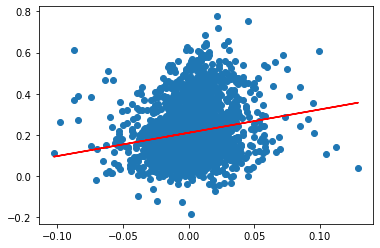

In [99]:
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

## Evaluate model quality

In [100]:
print(model.coef_)
print(model.intercept_)

[1.13031361]
0.21078970230186223


In [101]:
r2_score(y, y_pred)


0.03572712347756213

In [102]:
mean_squared_error(y, y_pred)

0.01554903399324957